In [7]:
pip install --upgrade pyarrow


Note: you may need to restart the kernel to use updated packages.


In [3]:
from pathlib import Path
import pandas as pd
import sys

# Path setup
PROJECT_ROOT = Path(r"C:\Users\Arushi Sharma\Documents\retail_demand_forecasting")
DATA_DIR = PROJECT_ROOT / "data"
sys.path.append(str((PROJECT_ROOT / "utils").resolve()))

# Import feature engineering
from feature_engineering import create_features

# Load cleaned data
df = pd.read_parquet(DATA_DIR / "cleaned_rossmann.parquet")

# Feature engineering (including corrected datetime format)
df["Promo2Since"] = pd.to_datetime(
    df["Promo2SinceYear"].fillna(0).astype(int).astype(str) + "-01",
    format="%Y-%m", errors='coerce'
)

df = create_features(df)
df = df.dropna(subset=["SalesLag1", "SalesLag7", "SalesMA7"])  # Drop NaNs from lag features

# Optional: save the feature-enhanced dataset
df.to_csv(DATA_DIR / "features_rossmann.csv", index=False)

df.head()

df.to_csv(DATA_DIR / "features_rossmann.csv", index=False)


C:\Users\Arushi Sharma\Documents\retail_demand_forecasting\utils\feature_engineering.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Promo2Since"] = pd.to_datetime(


In [5]:
!pip install scikit-learn


  Using cached scipy-1.16.1-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ----------------- ---------------------- 3.9/8.9 MB 21.3 MB/s eta 0:00:01
   ----------------------------------- ---- 7.9/8.9 MB 20.3 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 19.1 MB/s  0:00:00
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached scipy-1.16.1-cp311-cp311-win_amd64.whl (38.6 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4 [scipy]
   ---------- ----------------------------- 1/4

In [26]:
from sklearn.model_selection import train_test_split

# Drop rows with NaNs in target
df = df.dropna(subset=["Sales"])

# Sort by date
df = df.sort_values("Date")

# Select features
FEATURES = ["Store", "DayOfWeek", "Month", "IsWeekend", "SalesLag1", "SalesLag7", "SalesMA7"]
TARGET = "Sales"

# Split 80% train, 20% test (time-based)
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_test, y_test = test_df[FEATURES], test_df[TARGET]



In [8]:
!pip install xgboost


  Using cached xgboost-3.0.5-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.5-py3-none-win_amd64.whl (56.8 MB)


In [5]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize and train the model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f}")


Test RMSE: 1631.44


In [10]:
import joblib

model_path = PROJECT_ROOT / "models" / "xgb_model.pkl"
joblib.dump(model, model_path)
print(f"Model saved to: {model_path}")


Model saved to: C:\Users\Arushi Sharma\Documents\retail_demand_forecasting\models\xgb_model.pkl


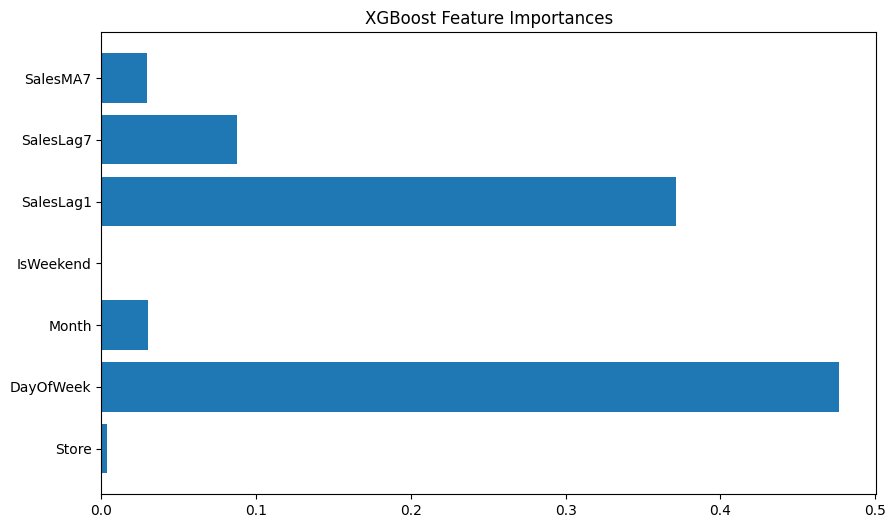

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
xgb_importances = model.feature_importances_
plt.barh(FEATURES, xgb_importances)
plt.title("XGBoost Feature Importances")
plt.show()


In [12]:
pip install shap


  Using cached shap-0.48.0-cp311-cp311-win_amd64.whl.metadata (25 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.61.2-cp311-cp311-win_amd64.whl.metadata (2.9 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached llvmlite-0.44.0-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
  Using cached numpy-2.2.6-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached shap-0.48.0-cp311-cp311-win_amd64.whl (544 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Using cached numba-0.61.2-cp311-cp311-win_amd64.whl (2.8 MB)
Using cached llvmlite-0.44.0-cp311-cp311-win_amd64.whl (30.3 MB)
Using cached numpy-2.2.6-cp311-cp311-win_amd64.whl (12.9 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)

   ----- ---------------------------------- 1/7 [slicer]
  Attempting uninstall: numpy
   ----- --------------------

  You can safely remove it manually.
  You can safely remove it manually.


In [6]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Define features and target
FEATURES = ["Store", "DayOfWeek", "Month", "IsWeekend", "SalesLag1", "SalesLag7", "SalesMA7"]
TARGET = "Sales"

X = df[FEATURES]
y = df[TARGET]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [22]:
import pandas as pd
from pathlib import Path

# Set your project root
PROJECT_ROOT = Path(r"C:\Users\Arushi Sharma\Documents\retail_demand_forecasting")
DATA_DIR = PROJECT_ROOT / "data"

# Load the CSV
df = pd.read_csv(DATA_DIR / "features_rossmann.csv")

# 🔧 Convert StateHoliday to string to avoid mixed-type issue
df["StateHoliday"] = df["StateHoliday"].astype(str)

# Save to Parquet
df.to_parquet(DATA_DIR / "features_rossmann.parquet", index=False)
print("✅ Saved as Parquet:", DATA_DIR / "features_rossmann.parquet")



✅ Saved as Parquet: C:\Users\Arushi Sharma\Documents\retail_demand_forecasting\data\features_rossmann.parquet


In [15]:
# Best practice: use same data in both explainer() and summary_plot()
sample = X_test.sample(500, random_state=42)
shap_values = explainer(sample)

# Summary Plot (global explainability)
shap.summary_plot(shap_values, sample, show=False)
plt.savefig(PLOT_DIR / "shap_summary_plot.png", bbox_inches='tight')
plt.close()  # Best practice: avoid overlapping plots


In [18]:
import matplotlib.pyplot as plt

# Save a SHAP waterfall plot as PNG
i = 10
shap.plots.waterfall(shap_values[i], max_display=10, show=False)
plt.savefig(PLOT_DIR / "shap_waterfall_sample10.png", bbox_inches='tight')
plt.close()  # Clean up


In [17]:
shap_df = pd.DataFrame({
    "Feature": sample.columns,
    "Mean |SHAP value|": np.abs(shap_values.values).mean(axis=0)
}).sort_values(by="Mean |SHAP value|", ascending=False)

shap_df.to_csv(PLOT_DIR / "shap_feature_importance.csv", index=False)


In [20]:
# Interactive force plot for one prediction
i = 10
force_plot = shap.plots.force(shap_values[i])

# Save as interactive HTML
# Correct version
shap.save_html(str(PLOT_DIR / "shap_force_sample10.html"), force_plot)

